In [2]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import pytesseract
pytesseract.pytesseract.tesseract_cmd = 'C:/Program Files/Tesseract-OCR/tesseract.exe'
import LPR

In [3]:
def plot_image(img, grayscale=True):
    plt.axis('off')
    if grayscale:
        plt.imshow(img, cmap='gray')
    else:
        plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
    plt.show()

In [7]:
idx = 2
lpr = LPR.LPR()

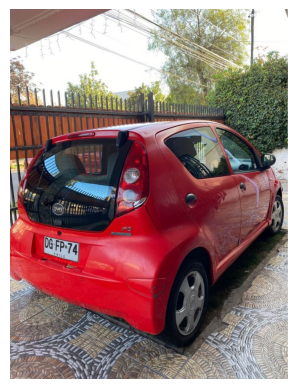

(959, 720, 3)


In [8]:
img = cv2.imread(f"./imgscl/{idx:03}.png")
plot_image(img, False)
print(img.shape)

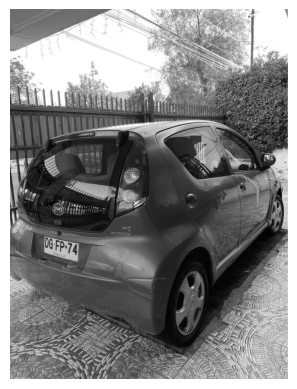

(959, 720)


In [9]:
gray = lpr.grayscale(img)
plot_image(gray)
print(gray.shape)

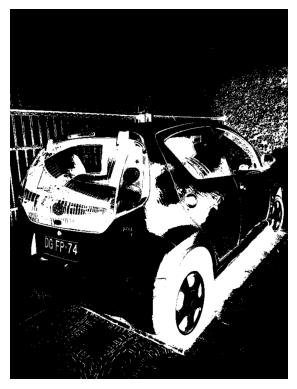

In [10]:
thresh = cv2.threshold(gray, 50, 255, cv2.THRESH_BINARY_INV)[1] #el numero 50 se modifica para cambiar los valores del thresh
# Tambien nos puede ayudar para que la imagen binaria destaque solo los objetos mas notorios.
plot_image(thresh)

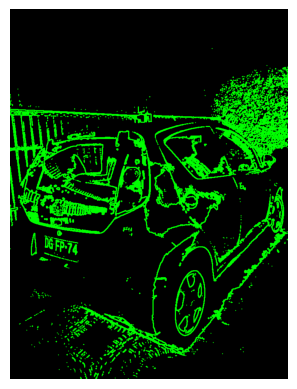

In [11]:
contours = lpr.find_contours(thresh)
canvas = np.zeros_like(img)
cv2.drawContours(canvas , contours, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas);

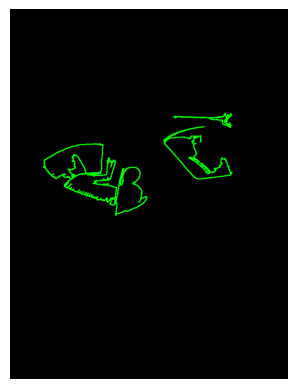

In [12]:
# Patente chilena dimensiones: Formato estándar: 360 mm de ancho por 130 mm de alto. 
# 360/130 = 2.769230769230769

# Filtrar contornos para encontrar candidatos a patentes
license_ratio = 2.769230769230769
min_w = 80
max_w = 360
min_h = 25
max_h = 130
candidates = []

for cnt in contours:
    x, y, w, h = cv2.boundingRect(cnt)
    aspect_ratio = float(w) / h
    if (np.isclose(aspect_ratio, license_ratio, atol=3) and # modificamos el atol para mas precision en los contornos de los objetos
        (max_w > w > min_w) and
        (max_h > h > min_h) and
        (x > img.shape[1] * 0.1) and
        (x + w < img.shape[1] * 0.9)):
        candidates.append(cnt)

canvas = np.zeros_like(img)
cv2.drawContours(canvas, candidates, -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas)
plt.show()




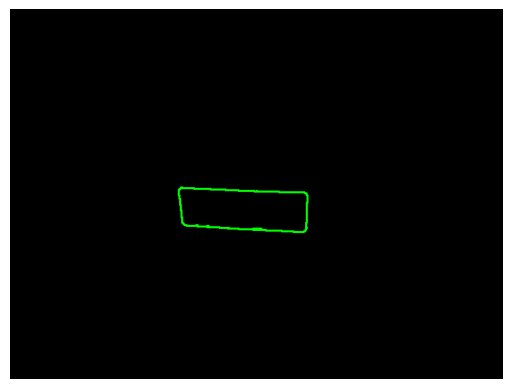

In [9]:
# Seleccionar el contorno con el menor valor de y (el más alto en la imagen)
ys = []
for cnt in candidates:
    x, y, w, h = cv2.boundingRect(cnt)
    ys.append(y)

license_contour = candidates[np.argmin(ys)]  # Selecciona el contorno con la coordenada y mínima

# Resaltar solo la patente seleccionada
canvas = np.zeros_like(img)
cv2.drawContours(canvas, [license_contour], -1, (0, 255, 0), 2)
plt.axis('off')
plt.imshow(canvas)
plt.show()

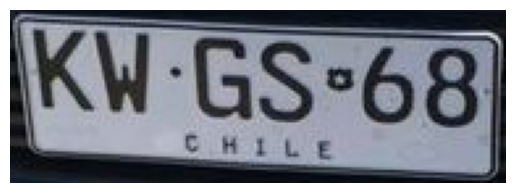

In [10]:
# Recortar la imagen de la patente
x, y, w, h = cv2.boundingRect(license_contour)
cropped = img[y:y+h, x:x+w]
plot_image(cropped, False)

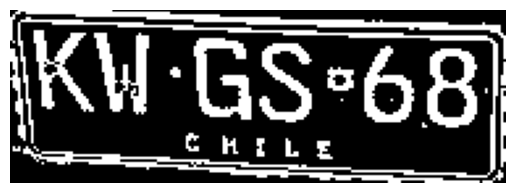

In [11]:
gray_cropped = cv2.cvtColor(cropped, cv2.COLOR_BGR2GRAY)
thresh_cropped = cv2.adaptiveThreshold(gray_cropped, 255, cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY_INV, 7, 13)
plot_image(thresh_cropped)

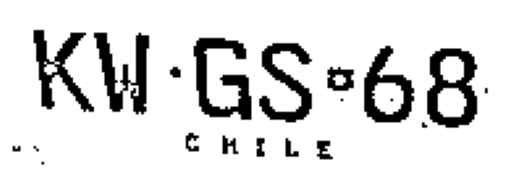

In [12]:
clear_border = lpr.clear_border(thresh_cropped)
final = lpr.invert_image(clear_border)
plot_image(final)

In [15]:
psm = 7
alphanumeric = "ABCDEFGHIJKLMNOPQRSTUVWXYZ0123456789"
options = "-c tessedit_char_whitelist={}".format(alphanumeric)
options += " --psm {}".format(psm)
txt = pytesseract.image_to_string(final, config=options)
print(txt[:2], txt[2:4], txt[4:6]) #print de los datos.

KW GS 68
